## Imports

In [29]:
# IMPORTS
# ML
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pycountry
import rasterio
from scipy.spatial import cKDTree
from tqdm import tqdm
from datetime import datetime
import geopandas as gpd

import zipfile
import os
import gdown

# Contry data

In [30]:
country_info_path = (
    "https://drive.google.com/uc?id=1xfYlruvfAi6yieOd_S69pPYWphckRLr5&export=download"
)

column_names = [
    "Country_Code",  # Alpha-2 code
    "ISO_Alpha_3",  # Alpha-3 code
    "Numeric_Code",  # Numeric code
    "Alpha_2",  # Alpha-2 code (duplicate)
    "Country_Name",  # Name of the country
    "Capital",  # Capital city
    "Area",  # Area in square kilometers
    "Population",  # Population
    "Region",  # Region
    "TLD",  # Top-level domain
    "Currency_Code",  # Currency code
    "Currency_Name",  # Currency name
    "Currency_Numeric",  # Numeric currency code
    "Additional_Info",  # Additional information
]

country_info_df = pd.read_csv(
    country_info_path, delimiter="\t", comment="#", on_bad_lines="skip", header=None
)

country_info_df.columns = column_names
country_info_df.head()

,Country_Code,ISO_Alpha_3,Numeric_Code,Alpha_2,Country_Name,Capital,Area,Population,Region,TLD,Currency_Code,Currency_Name,Currency_Numeric,Additional_Info
0,AD,AND,20,AN,Andorra,Andorra la Vella,468.0,77006,EU,.ad,EUR,Euro,376,AD
1,AE,ARE,784,AE,United Arab Emirates,Abu Dhabi,82880.0,9630959,AS,.ae,AED,Dirham,971,NaN
2,AI,AIA,660,AV,Anguilla,The Valley,102.0,13254,NaN,.ai,XCD,Dollar,+1-264,AI-
3,AL,ALB,8,AL,Albania,Tirana,28748.0,2866376,EU,.al,ALL,Lek,355,NaN
4,AM,ARM,51,AM,Armenia,Yerevan,29800.0,2951776,AS,.am,AMD,Dram,374,NaN


## Countries 

In [31]:
countries_zip_url = "https://drive.google.com/uc?id=1UQzdO7suT0BnwKBeNybMG97vM9GIDogA"
countries_zip_file_path = "../../allCountries.zip"

# Download the ZIP file if it doesn't exist; otherwise, proceed to read the TXT file.
if not os.path.exists(countries_zip_file_path):
    gdown.download(countries_zip_url, countries_zip_file_path, quiet=False)

with zipfile.ZipFile(countries_zip_file_path) as z:
    countries_txt_filename = "allCountries.txt"

    with z.open(countries_txt_filename) as txt_file:
        countries_df = pd.read_csv(txt_file, sep="\t", header=None)


# https://download.geonames.org/export/dump/
countries_df.columns = [
    "geonameid",
    "name",
    "asciiname",
    "alternatenames",
    "latitude",
    "longitude",
    "feature class",
    "feature code",
    "iso alpha 2",
    "cc2",
    "admin1 code",
    "admin2 code",
    "admin3 code",
    "admin4 code",
    "population",
    "elevation",
    "dem",
    "timezone",
    "modification date",
]

print(f"\nshape: {countries_df.shape}")
countries_df.head()

Downloading...
From (original): https://drive.google.com/uc?id=1UQzdO7suT0BnwKBeNybMG97vM9GIDogA
From (redirected): https://drive.google.com/uc?id=1UQzdO7suT0BnwKBeNybMG97vM9GIDogA&confirm=t&uuid=41f7621b-c5e3-4567-a2d4-7df1f35bd5bd
To: /Users/leilei/Documents/MIDS/2024 Fall/allCountries.zip
100%|██████████| 402M/402M [00:07<00:00, 56.8MB/s] 
/var/folders/jj/8606n51j7y5c8djfw8nf8_640000gn/T/ipykernel_45570/1495126749.py:12: DtypeWarning: Columns (9,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  countries_df = pd.read_csv(txt_file, sep="\t", header=None)



shape: (12950185, 19)


,geonameid,name,asciiname,alternatenames,latitude,longitude,feature class,feature code,iso alpha 2,cc2,admin1 code,admin2 code,admin3 code,admin4 code,population,elevation,dem,timezone,modification date
0,2994701,Roc Meler,Roc Meler,"Roc Mele,Roc Meler,Roc Mélé",42.58765,1.74180,T,PK,AD,"AD,FR",02,NaN,NaN,NaN,0,2811.0,2348,Europe/Andorra,2023-10-03
1,3017832,Pic de les Abelletes,Pic de les Abelletes,"Pic de la Font-Negre,Pic de la Font-Nègre,Pic ...",42.52535,1.73343,T,PK,AD,FR,A9,66,663.0,66146.0,0,NaN,2411,Europe/Andorra,2014-11-05
2,3017833,Estany de les Abelletes,Estany de les Abelletes,"Estany de les Abelletes,Etang de Font-Negre,Ét...",42.52915,1.73362,H,LK,AD,FR,A9,NaN,NaN,NaN,0,NaN,2260,Europe/Andorra,2014-11-05
3,3023203,Port Vieux de la Coume d’Ose,Port Vieux de la Coume d'Ose,"Port Vieux de Coume d'Ose,Port Vieux de Coume ...",42.62568,1.61823,T,PASS,AD,NaN,00,NaN,NaN,NaN,0,NaN,2687,Europe/Andorra,2014-11-05
4,3029315,Port de la Cabanette,Port de la Cabanette,"Port de la Cabanette,Porteille de la Cabanette",42.60000,1.73333,T,PASS,AD,"AD,FR",B3,09,91.0,9139.0,0,NaN,2379,Europe/Andorra,2014-11-05


## EUI

In [32]:
eui_url = "https://drive.google.com/uc?id=12qGq_DLefI1RihIF_RKQUyJtm480-xRC"
eui_df = pd.read_csv(eui_url)

print(f"shape: {eui_df.shape}")
eui_df.head()

shape: (482, 5)


,City,Geonames ID,Country,Residential EUI (kWh/m2/year),Non-residential EUI (kWh/m2/year)
0,Nha Trang,1572151,Vietnam,59.096065,112.778867
1,Aberdeen,2657832,United Kingdom,231.302877,259.832393
2,Abidjan,2293538,Cote d'Ivoire,73.830819,105.622137
3,Abu Dhabi,292968,United Arab Emirates,128.447899,226.725457
4,Abuja,2352778,Nigeria,63.955819,103.009079


In [33]:
merged_df = pd.merge(
    countries_df, eui_df, left_on="geonameid", right_on="Geonames ID", how="inner"
)
assert merged_df.shape[0] == eui_df.shape[0]
print(f"shape: {merged_df.shape}")
merged_df.head()

shape: (482, 24)


,geonameid,name,asciiname,alternatenames,latitude,longitude,feature class,feature code,iso alpha 2,cc2,...,population,elevation,dem,timezone,modification date,City,Geonames ID,Country,Residential EUI (kWh/m2/year),Non-residential EUI (kWh/m2/year)
0,292968,Abu Dhabi,Abu Dhabi,"A-pu-that-pi,AEbu Saby,AUH,Aboe Dhabi,Abou Dab...",24.45118,54.39696,P,PPLC,AE,NaN,...,1807000,NaN,6,Asia/Dubai,2024-03-27,Abu Dhabi,292968,United Arab Emirates,128.447899,226.725457
1,1138958,Kabul,Kabul,"Cabool,Caboul,Cabul,Cabura,Cabúl,Caubul,KBL,Ka...",34.52813,69.17233,P,PPLC,AF,NaN,...,4434550,NaN,1798,Asia/Kabul,2024-09-05,Kabul,1138958,Afghanistan,213.167026,144.395840
2,3183875,Tirana,Tirana,"TIA,Terana,Theranda,Tiorana,Tiorána,Tiran,Tira...",41.32750,19.81889,P,PPLC,AL,NaN,...,418495,NaN,113,Europe/Tirane,2023-01-01,Tirana,3183875,Albania,133.717672,101.873579
3,616052,Yerevan,Yerevan,"Ayrivan,Djerevan,EVN,Eireavan,Eireaván,Ereban,...",40.18111,44.51361,P,PPLC,AM,NaN,...,1093485,NaN,994,Asia/Yerevan,2023-11-13,Yerevan,616052,Armenia,198.865302,132.124738
4,2240449,Luanda,Luanda,"LAD,Loanda,Louanda,Louanta,Luand,Luanda,Luanda...",-8.83682,13.23432,P,PPLC,AO,NaN,...,2776168,NaN,73,Africa/Luanda,2024-03-26,Luanda,2240449,Angola,65.343750,104.311100


## Adding ISO 3 Code

In [34]:
# Adding ISO CODE 3
alpha_2_to_alpha_3 = {
    country.alpha_2: country.alpha_3 for country in pycountry.countries
}
merged_df.loc[:, "ISO_alpha3"] = merged_df["iso alpha 2"].map(alpha_2_to_alpha_3)

# Manually correcting the missing country code for Namibia by assigning 'NAM' because country code is null for Nambia
merged_df.loc[merged_df["Country"] == "Namibia", "ISO_alpha3"] = "NAM"
merged_df.loc[merged_df["Country"] == "Namibia", "iso alpha 2"] = "NA"

print(f"shape: {merged_df.shape}")

assert (
    merged_df["ISO_alpha3"].isna().sum() == 0
), "There are missing values in the ISO_alpha3 column."
assert merged_df.shape[0] == 482, "The number of rows in merged_df is not 482."

shape: (482, 25)


# Temperature

In [14]:
# A function to retrive multipal days and hours temp data from API

import cdsapi
from datetime import datetime, timedelta
import time


def download_temperature_data(
    start_date_str, end_date_str, hours, api_key=None, rate_limit_seconds=1
):
    """
    Download temperature data (2m temperature) for multiple days and hours using the CDS API.

    Args:
    - start_date_str (str): Start date in 'YYYY-MM-DD' format.
    - end_date_str (str): End date in 'YYYY-MM-DD' format.
    - hours (list): List of hours to download data for (e.g., ['00:00', '03:00', '06:00']).
    - api_key (str, optional): API key if needed. Default is None.
    - rate_limit_seconds (int): Time to wait between API requests to avoid hitting rate limits. Default is 1 second.

    Returns:
    - None. Data will be downloaded and saved as .nc files for each day.
    """

    # Initialize the CDS API client
    c = cdsapi.Client(
        url="https://cds-beta.climate.copernicus.eu/api",
        key="384d14bf-681e-44c7-9f2b-4f12ebb18f12",
    )

    # Parse the start and end dates
    start_date = datetime.strptime(start_date_str, "%Y-%m-%d")
    end_date = datetime.strptime(end_date_str, "%Y-%m-%d")

    # Loop through the date range
    current_date = start_date

    while current_date <= end_date:
        try:
            # Format the date strings for the API request
            year = current_date.strftime("%Y")
            month = current_date.strftime("%m")
            day = current_date.strftime("%d")

            # Log start time for download
            start_time = time.time()

            # Request data from the API
            print(
                f"Requesting data for {current_date.strftime('%Y-%m-%d')} at times: {hours}"
            )
            c.retrieve(
                "reanalysis-era5-single-levels",
                {
                    "product_type": "reanalysis",
                    "format": "netcdf",
                    "variable": "2m_dewpoint_temperature",
                    "year": year,
                    "month": month,
                    "day": day,
                    "time": hours,  # List of hours to query
                },
                f"download_{year}{month}{day}.nc",  # Save with unique filename
            )

            # Log end time for download
            end_time = time.time()
            print(
                f"Download for {year}-{month}-{day} took {end_time - start_time:.2f} seconds."
            )

            # Move to the next day
            current_date += timedelta(days=1)

            # Sleep to avoid rate limits
            time.sleep(rate_limit_seconds)

        except Exception as e:
            print(
                f"Failed to download data for {current_date.strftime('%Y-%m-%d')}: {e}"
            )
            current_date += timedelta(
                days=1
            )  # Move to the next day even if there's an error

    print("Data download completed.")


# Example usage:
start_date = "2023-1-01"  # Start date
end_date = "2023-1-31"  # End date
hours = [
    "00:00",
    "03:00",
    "06:00",
    "09:00",
    "12:00",
    "15:00",
    "18:00",
    "21:00",
]  # List of hours to query

# Call the function to download data
download_temperature_data(start_date, end_date, hours, rate_limit_seconds=2)

2024-11-21 00:43:41,408 WARNING [2024-11-19T00:00:00] Issue with underlaying infrastructure is now solved. System should gradually recover. Please check updated status [here](https://status.ecmwf.int/)
2024-11-21 00:43:41,409 INFO [2024-09-28T00:00:00] **Welcome to the New Climate Data Store (CDS)!** This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your 
[feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is key to improve the user experience on the new CDS for the benefit of everyone. Thank you.
2024-11-21 00:43:41,410 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2024-11-21 00:43:41,411 INFO [2024-09-16T00:00:00] Remember that you need to have an ECMWF account to use the new CDS. **Your old CDS credentials will not work in new CDS!**
2024-11-21 00:43:41,412 WARNING [2024-06-16T00:00:00] CDS 

Requesting data for 2023-01-01 at times: ['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00']


2024-11-21 00:43:42,227 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-21 00:43:42,228 INFO Request ID is dc45af08-5116-4890-9fef-6fa6fc18f7cb
2024-11-21 00:43:42,365 INFO status has been updated to accepted
2024-11-21 00:43:51,123 INFO status has been updated to running
2024-11-21 00:43:56,319 INFO status has been updated to successful


Download for 2023-01-01 took 17.36 seconds.
Requesting data for 2023-01-02 at times: ['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00']


2024-11-21 00:44:01,709 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-21 00:44:01,710 INFO Request ID is 731af593-9b12-45a9-a98d-9f461d4d04b4
2024-11-21 00:44:01,896 INFO status has been updated to accepted
2024-11-21 00:44:11,101 INFO status has been updated to running
2024-11-21 00:44:16,387 INFO status has been updated to accepted
2024-11-21 00:44:24,129 INFO status has been updated to successful


Download for 2023-01-02 took 26.72 seconds.
Requesting data for 2023-01-03 at times: ['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00']


2024-11-21 00:44:30,250 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-21 00:44:30,251 INFO Request ID is 737cef72-f87e-41f4-be6d-00cae4daeeb2
2024-11-21 00:44:30,395 INFO status has been updated to accepted
2024-11-21 00:44:44,458 INFO status has been updated to running
2024-11-21 00:44:52,187 INFO status has been updated to accepted
2024-11-21 00:45:03,767 INFO status has been updated to successful


Download for 2023-01-03 took 37.46 seconds.
Requesting data for 2023-01-04 at times: ['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00']


2024-11-21 00:45:09,840 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-21 00:45:09,841 INFO Request ID is 4e803f9b-bd75-4234-be74-4c7e63e8ee3c
2024-11-21 00:45:10,076 INFO status has been updated to accepted
2024-11-21 00:45:15,336 INFO status has been updated to running
2024-11-21 00:45:24,104 INFO status has been updated to successful


Download for 2023-01-04 took 17.90 seconds.
Requesting data for 2023-01-05 at times: ['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00']


2024-11-21 00:45:29,618 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-21 00:45:29,619 INFO Request ID is bfcf7903-c140-4ce4-af5d-16690b0a6744
2024-11-21 00:45:29,903 INFO status has been updated to accepted
2024-11-21 00:45:32,749 INFO status has been updated to running
2024-11-21 00:45:43,963 INFO status has been updated to successful


Download for 2023-01-05 took 18.43 seconds.
Requesting data for 2023-01-06 at times: ['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00']


2024-11-21 00:45:49,971 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-21 00:45:49,972 INFO Request ID is 41563cdb-89b0-4da7-afbe-f4d038c429c1
2024-11-21 00:45:50,137 INFO status has been updated to accepted
2024-11-21 00:45:55,476 INFO status has been updated to running
2024-11-21 00:46:04,271 INFO status has been updated to successful


Download for 2023-01-06 took 18.01 seconds.
Requesting data for 2023-01-07 at times: ['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00']


2024-11-21 00:46:10,919 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-21 00:46:10,920 INFO Request ID is 7797a1e8-8799-495a-b2e7-3aae4138582a
2024-11-21 00:46:11,099 INFO status has been updated to accepted
2024-11-21 00:46:14,109 INFO status has been updated to running
2024-11-21 00:46:25,335 INFO status has been updated to successful


Download for 2023-01-07 took 20.01 seconds.
Requesting data for 2023-01-08 at times: ['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00']


2024-11-21 00:46:32,059 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-21 00:46:32,060 INFO Request ID is f5c71593-5984-4673-a463-99e95a5566d4
2024-11-21 00:46:32,183 INFO status has been updated to accepted
2024-11-21 00:46:37,479 INFO status has been updated to running
2024-11-21 00:46:41,148 INFO status has been updated to successful


Download for 2023-01-08 took 12.54 seconds.
Requesting data for 2023-01-09 at times: ['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00']


2024-11-21 00:46:46,633 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-21 00:46:46,633 INFO Request ID is d3224542-bf25-40c0-bcfd-ba7946f6abf1
2024-11-21 00:46:46,767 INFO status has been updated to accepted
2024-11-21 00:46:52,130 INFO status has been updated to running
2024-11-21 00:47:00,982 INFO status has been updated to successful


Download for 2023-01-09 took 17.59 seconds.
Requesting data for 2023-01-10 at times: ['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00']


2024-11-21 00:47:06,332 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-21 00:47:06,333 INFO Request ID is b2a2f620-5508-4ad9-9ab5-e803a5124744
2024-11-21 00:47:06,458 INFO status has been updated to accepted
2024-11-21 00:47:16,013 INFO status has been updated to running
2024-11-21 00:47:21,276 INFO status has been updated to successful


Download for 2023-01-10 took 19.28 seconds.
Requesting data for 2023-01-11 at times: ['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00']


2024-11-21 00:47:27,766 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-21 00:47:27,767 INFO Request ID is 0990e3d5-6fec-4e83-9bef-16997c257930
2024-11-21 00:47:27,896 INFO status has been updated to accepted
2024-11-21 00:47:33,067 INFO status has been updated to running
2024-11-21 00:47:36,651 INFO status has been updated to successful


Download for 2023-01-11 took 13.27 seconds.
Requesting data for 2023-01-12 at times: ['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00']


2024-11-21 00:47:43,088 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-21 00:47:43,089 INFO Request ID is da1cc5af-3040-42c6-9516-fde93147a4de
2024-11-21 00:47:43,307 INFO status has been updated to accepted
2024-11-21 00:47:52,367 INFO status has been updated to running
2024-11-21 00:47:57,679 INFO status has been updated to accepted
2024-11-21 00:48:05,771 INFO status has been updated to successful


Download for 2023-01-12 took 26.82 seconds.
Requesting data for 2023-01-13 at times: ['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00']


2024-11-21 00:48:12,308 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-21 00:48:12,309 INFO Request ID is 234ee3de-05fc-410c-af5c-b0889df4fd67
2024-11-21 00:48:12,487 INFO status has been updated to accepted
2024-11-21 00:48:15,294 INFO status has been updated to running
2024-11-21 00:48:21,471 INFO status has been updated to successful


Download for 2023-01-13 took 14.75 seconds.
Requesting data for 2023-01-14 at times: ['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00']


2024-11-21 00:48:28,294 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-21 00:48:28,294 INFO Request ID is 5be5a8e8-5929-4bb1-a3fd-df5140c6e375
2024-11-21 00:48:28,418 INFO status has been updated to accepted
2024-11-21 00:48:31,623 INFO status has been updated to running
2024-11-21 00:48:37,519 INFO status has been updated to successful


Download for 2023-01-14 took 13.53 seconds.
Requesting data for 2023-01-15 at times: ['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00']


2024-11-21 00:48:41,831 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-21 00:48:41,832 INFO Request ID is 73b0188e-0b3a-425c-be44-1471cb0c5f28
2024-11-21 00:48:41,963 INFO status has been updated to accepted
2024-11-21 00:48:44,832 INFO status has been updated to running
2024-11-21 00:48:50,841 INFO status has been updated to successful


Download for 2023-01-15 took 13.20 seconds.
Requesting data for 2023-01-16 at times: ['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00']


2024-11-21 00:48:56,948 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-21 00:48:56,949 INFO Request ID is adebe671-b6f4-44c8-9bd1-7d23ee945881
2024-11-21 00:48:57,073 INFO status has been updated to accepted
2024-11-21 00:49:02,309 INFO status has been updated to running
2024-11-21 00:49:06,232 INFO status has been updated to successful


Download for 2023-01-16 took 13.26 seconds.
Requesting data for 2023-01-17 at times: ['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00']


2024-11-21 00:49:12,691 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-21 00:49:12,693 INFO Request ID is 95bf35c0-6d61-4c5a-af3f-88a54dafc3a9
2024-11-21 00:49:12,906 INFO status has been updated to accepted
2024-11-21 00:49:18,392 INFO status has been updated to running
2024-11-21 00:49:21,901 INFO status has been updated to successful


Download for 2023-01-17 took 13.25 seconds.
Requesting data for 2023-01-18 at times: ['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00']


2024-11-21 00:49:27,863 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-21 00:49:27,864 INFO Request ID is f084a5b1-04f4-4aec-9925-cb7448b29427
2024-11-21 00:49:27,991 INFO status has been updated to accepted
2024-11-21 00:49:36,730 INFO status has been updated to running
2024-11-21 00:49:49,971 INFO status has been updated to successful


Download for 2023-01-18 took 26.83 seconds.
Requesting data for 2023-01-19 at times: ['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00']


2024-11-21 00:49:57,073 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-21 00:49:57,074 INFO Request ID is 94d3c2e1-40e8-49ea-ba33-84935efdfed6
2024-11-21 00:49:57,198 INFO status has been updated to accepted
2024-11-21 00:50:06,398 INFO status has been updated to running
2024-11-21 00:50:11,681 INFO status has been updated to successful


Download for 2023-01-19 took 19.88 seconds.
Requesting data for 2023-01-20 at times: ['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00']


2024-11-21 00:50:18,184 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-21 00:50:18,185 INFO Request ID is fca41c96-88b9-4b80-ac3c-9cb1ec6042d4
2024-11-21 00:50:18,388 INFO status has been updated to accepted
2024-11-21 00:50:21,212 INFO status has been updated to running
2024-11-21 00:50:27,104 INFO status has been updated to successful


Download for 2023-01-20 took 12.51 seconds.
Requesting data for 2023-01-21 at times: ['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00']


2024-11-21 00:50:32,785 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-21 00:50:32,785 INFO Request ID is fecb1728-e0f4-465d-b01d-e92f0e9515c7
2024-11-21 00:50:32,914 INFO status has been updated to accepted
2024-11-21 00:50:38,097 INFO status has been updated to running
2024-11-21 00:50:46,849 INFO status has been updated to successful


Download for 2023-01-21 took 18.33 seconds.
Requesting data for 2023-01-22 at times: ['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00']


2024-11-21 00:50:53,118 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-21 00:50:53,119 INFO Request ID is 2f46fd4f-23f0-4d5c-9cf0-8cb914df44f5
2024-11-21 00:50:53,245 INFO status has been updated to accepted
2024-11-21 00:50:56,106 INFO status has been updated to running
2024-11-21 00:51:02,163 INFO status has been updated to successful


Download for 2023-01-22 took 13.35 seconds.
Requesting data for 2023-01-23 at times: ['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00']


2024-11-21 00:51:08,442 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-21 00:51:08,443 INFO Request ID is d6a8f6df-f652-4721-b32b-bcbfff4344c9
2024-11-21 00:51:08,565 INFO status has been updated to accepted
2024-11-21 00:51:13,794 INFO status has been updated to running
2024-11-21 00:51:22,522 INFO status has been updated to successful


Download for 2023-01-23 took 17.70 seconds.
Requesting data for 2023-01-24 at times: ['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00']


2024-11-21 00:51:28,334 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-21 00:51:28,335 INFO Request ID is dbfc8f05-340a-451a-b33c-812e2151967e
2024-11-21 00:51:28,476 INFO status has been updated to accepted
2024-11-21 00:51:37,219 INFO status has been updated to running
2024-11-21 00:51:50,149 INFO status has been updated to successful


Download for 2023-01-24 took 31.50 seconds.
Requesting data for 2023-01-25 at times: ['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00']


2024-11-21 00:52:02,316 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-21 00:52:02,317 INFO Request ID is 0687e2bf-2e70-4f2a-85c5-5ed9b6543796
2024-11-21 00:52:02,488 INFO status has been updated to accepted
2024-11-21 00:52:05,365 INFO status has been updated to running
2024-11-21 00:52:11,387 INFO status has been updated to successful


Download for 2023-01-25 took 14.00 seconds.
Requesting data for 2023-01-26 at times: ['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00']


2024-11-21 00:52:17,702 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-21 00:52:17,703 INFO Request ID is 50a7923b-d0c2-4c44-b813-d2329d34554a
2024-11-21 00:52:17,830 INFO status has been updated to accepted
2024-11-21 00:52:23,006 INFO status has been updated to running
2024-11-21 00:52:31,784 INFO status has been updated to successful


Download for 2023-01-26 took 18.32 seconds.
Requesting data for 2023-01-27 at times: ['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00']


2024-11-21 00:52:38,124 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-21 00:52:38,125 INFO Request ID is 096fd14a-11ed-475a-b65d-c1c7ebe26fa4
2024-11-21 00:52:38,250 INFO status has been updated to accepted
2024-11-21 00:52:43,464 INFO status has been updated to running
2024-11-21 00:52:52,258 INFO status has been updated to successful


Download for 2023-01-27 took 18.15 seconds.
Requesting data for 2023-01-28 at times: ['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00']


2024-11-21 00:52:58,137 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-21 00:52:58,138 INFO Request ID is 7e33cd32-cc87-4340-920f-6687e2b52df5
2024-11-21 00:52:58,325 INFO status has been updated to accepted
2024-11-21 00:53:03,583 INFO status has been updated to running
2024-11-21 00:53:12,561 INFO status has been updated to accepted
2024-11-21 00:53:20,289 INFO status has been updated to successful


Download for 2023-01-28 took 29.45 seconds.
Requesting data for 2023-01-29 at times: ['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00']


2024-11-21 00:53:29,574 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-21 00:53:29,575 INFO Request ID is db390e88-870e-481e-a2d6-e4d45269aa94
2024-11-21 00:53:29,696 INFO status has been updated to accepted
2024-11-21 00:53:34,927 INFO status has been updated to running
2024-11-21 00:53:43,812 INFO status has been updated to successful


Download for 2023-01-29 took 17.68 seconds.
Requesting data for 2023-01-30 at times: ['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00']


2024-11-21 00:53:49,283 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-21 00:53:49,284 INFO Request ID is 8c64dd84-f03b-413b-8a50-7f3c3ee6159c
2024-11-21 00:53:49,419 INFO status has been updated to accepted
2024-11-21 00:53:54,717 INFO status has been updated to running
2024-11-21 00:53:58,217 INFO status has been updated to successful


Download for 2023-01-30 took 20.13 seconds.
Requesting data for 2023-01-31 at times: ['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00']


2024-11-21 00:54:11,424 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T from July 2024 until further notice - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-11-21 00:54:11,425 INFO Request ID is c7c0e300-cb25-499e-9ab9-e0a61dac60b4
2024-11-21 00:54:11,719 INFO status has been updated to accepted
2024-11-21 00:54:17,310 INFO status has been updated to running
2024-11-21 00:54:26,141 INFO status has been updated to successful


Download for 2023-01-31 took 18.65 seconds.
Data download completed.


In [25]:
# Compile daily data into monthly file
import xarray as xr
import os
import calendar

data_dir = "/Users/leilei/Documents/MIDS/2024 Fall/Capstone/Capstone-Team-Climate-Trace/"
# Define the year for which you want to combine the files
year = 2023
month = 1
days_in_month = calendar.monthrange(year, month)[1]

file_list = []

for day in range(1, 32):  # Loop over the days (1 to 31)
    try:
        for day in range(1, days_in_month + 1):
            file_name = f"download_{year:04d}{month:02d}{day:02d}.nc"
        file_path = os.path.join(data_dir, file_name)
        if os.path.exists(file_path):
            file_list.append(file_path)
    except ValueError:
        continue  # Skip invalid days (like 30th in February)

# Open all files and combine them into a single dataset
ds_list = [xr.open_dataset(file) for file in file_list]

# Combine datasets along the time dimension (or other appropriate dimensions)
combined_ds = xr.concat(ds_list, dim="time")  # Adjust dimension as needed

# Save the combined dataset to a single NetCDF file
combined_ds.to_netcdf(f"combined_{year}{month}.nc")

# Close all datasets
for ds in ds_list:
    ds.close()

In [207]:
# to caculate hdd--adapted from previous study in climate trace project with minumum adjustment
temp_thresh = 18


def get_hdd(temperature, temp_thresh):
    keep = temperature < temp_thresh
    hdd = np.zeros(temperature.shape)
    hdd[keep] = temp_thresh - temperature[keep]
    return hdd / 24  # Convert from heating degree hours to degree days


with rasterio.open(file_path) as src:
    celsius_factor = -273.15
    temp_conversion = lambda x: x + celsius_factor

    # blocky, blockx = src.block_shapes[0]
    n_lon = src.width
    n_lat = src.height
    left = src.bounds.left
    right = src.bounds.right
    bottom = src.bounds.bottom
    top = src.bounds.top
    new_count = 1
    # new_crs = rasterio.crs.CRS.from_string("EPSG:4326")
    new_crs = {"init": "epsg:4326"}
    new_transform = rasterio.transform.from_bounds(
        left, bottom, right, top, n_lon, n_lat
    )

    out_profile = {
        "driver": "GTiff",
        "dtype": "float64",
        "nodata": None,
        "width": n_lon,
        "height": n_lat,
        "count": new_count,
        "crs": new_crs,
        "transform": new_transform,
        "tiled": False,
        "interleave": "band",
        # 'blockxsize': blockx,
        # 'blockysize': blocky,
        "compress": "lzw",
        "driver": "GTiff",
        "dtype": "float64",
        "interleave": "band",
        "nodata": 99999999,
        # 'tiled': True}
    }

    yearly_hdd = np.zeros((n_lat, n_lon))

    for i in tqdm(src.indexes):
        # Read the data from this timepoint
        raw_data = src.read(i)
        # Get the quarter from which the data are from
        time = int(src.tags(i)["NETCDF_DIM_valid_time"])
        # Convert the temperature data to Celcius
        date_time = datetime.utcfromtimestamp(time)
        year = date_time.year

        temperature = temp_conversion(raw_data)
        # Compute the HDDs
        chdd = get_hdd(temperature, temp_thresh)

        yearly_hdd += chdd

        # # Accumulate HDDs only into the corresponding quarter----modify to
        # hdd_quarter[quarter] += chdd
lon_arr = np.linspace(left, right, n_lon)
lat_arr = np.linspace(bottom, top, n_lat)
lon_grid, lat_grid = np.meshgrid(lon_arr, lat_arr)
lon_flat = lon_grid.ravel()
lat_flat = lat_grid.ravel()
hdd_flat = yearly_hdd.ravel()

100%|██████████| 8/8 [00:00<00:00, 28.04it/s]


In [ ]:
# iteratively caculate hdd for compiled month data
import numpy as np
import rasterio
from tqdm import tqdm
from datetime import datetime

temp_thresh = 18
file_humidity = "../notebooks/combined_2023{}.nc"


def get_hdd(temperature, temp_thresh):
    keep = temperature < temp_thresh
    hdd = np.zeros(temperature.shape)
    hdd[keep] = temp_thresh - temperature[keep]
    return hdd / 24  # Convert from heating degree hours to degree days


# Placeholder arrays for latitude, longitude, and HDD results for each month
hdd_flat_dict = {}

# Loop over each month
for month in range(1, 13):
    file_path = file_template.format(f"{month}")

    with rasterio.open(file_path) as src:
        celsius_factor = -273.15
        temp_conversion = lambda x: x + celsius_factor

        n_lon = src.width
        n_lat = src.height
        left = src.bounds.left
        right = src.bounds.right
        bottom = src.bounds.bottom
        top = src.bounds.top

        # Initialize the HDD accumulator for this month
        monthly_hdd = np.zeros((n_lat, n_lon))

        for i in tqdm(src.indexes, desc=f"Processing month {month}"):
            # Read the data for the current timepoint
            raw_data = src.read(i)

            # Convert temperature data to Celsius
            temperature = temp_conversion(raw_data)

            # Compute the HDDs for this timepoint
            chdd = get_hdd(temperature, temp_thresh)

            # Accumulate HDDs for the entire month
            monthly_hdd += chdd

        # Flatten the HDD data for this month and store in the dictionary
        hdd_flat_dict[f"hdd_flat_{month}"] = monthly_hdd.ravel()

# Prepare latitude and longitude grids for the spatial coordinates
lon_arr = np.linspace(left, right, n_lon)
lat_arr = np.linspace(bottom, top, n_lat)
lon_grid, lat_grid = np.meshgrid(lon_arr, lat_arr)
lon_flat = lon_grid.ravel()
lat_flat = lat_grid.ravel()

Processing month 12: 100%|██████████| 248/248 [00:31<00:00,  7.89it/s]


In [10]:
# check in monthly hdd data
hdd_flat_dict
for month in range(1, 13):
    hdd_flat = hdd_flat_dict[f"hdd_flat_{month}"]
    print(
        f"Month {month}: Min HDD = {hdd_flat.min()}, Max HDD = {hdd_flat.max()}, Mean HDD = {hdd_flat.mean()}, Total HDD = {hdd_flat.sum()}"
    )

Month 1: Min HDD = 0.0, Max HDD = 681.716087977092, Mean HDD = 170.39843817781198, Total HDD = 176914474.4537315
Month 2: Min HDD = 0.0, Max HDD = 718.2451883951826, Mean HDD = 172.10727618269283, Total HDD = 178688658.423919
Month 3: Min HDD = 0.0, Max HDD = 803.0657234191904, Mean HDD = 164.191737436759, Total HDD = 170470429.47634068
Month 4: Min HDD = 0.0, Max HDD = 829.6255207061766, Mean HDD = 152.45668058784727, Total HDD = 158286624.05352655
Month 5: Min HDD = 0.0, Max HDD = 954.9157091776514, Mean HDD = 138.9413366538807, Total HDD = 144254453.3675251
Month 6: Min HDD = 0.0, Max HDD = 929.8193251291918, Mean HDD = 134.36634718062433, Total HDD = 139504516.2968114
Month 7: Min HDD = 0.0, Max HDD = 943.0603472391747, Mean HDD = 133.4448112762219, Total HDD = 138547740.85942465
Month 8: Min HDD = 0.0, Max HDD = 919.4969501495361, Mean HDD = 137.81808110282154, Total HDD = 143088244.52419344
Month 9: Min HDD = 0.0, Max HDD = 851.2294419606521, Mean HDD = 143.4593204121729, Total H

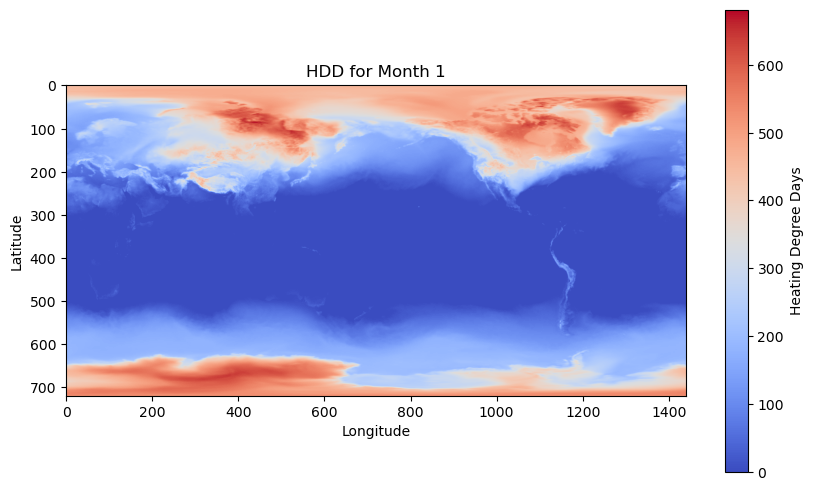

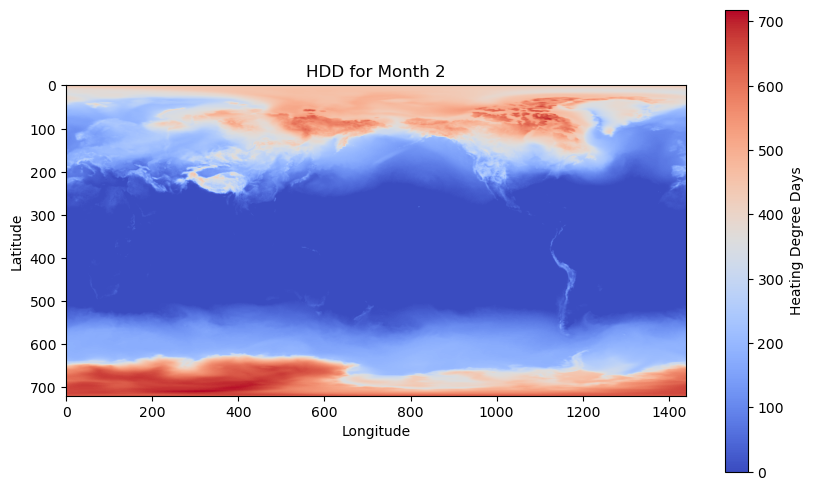

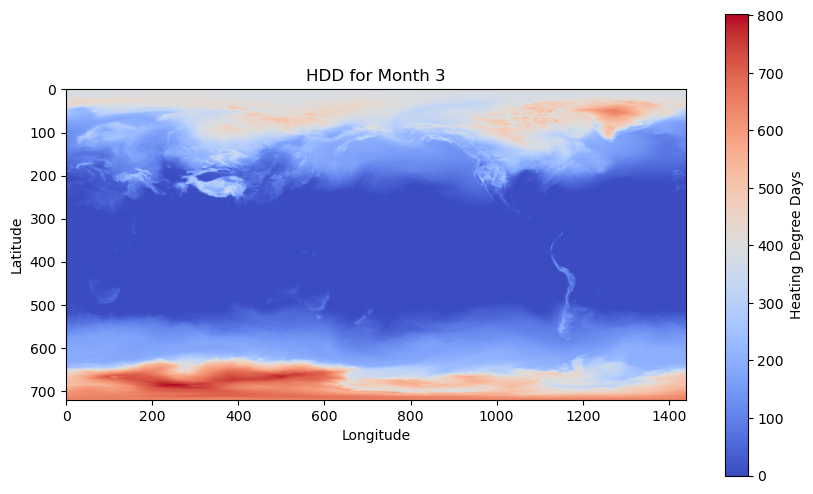

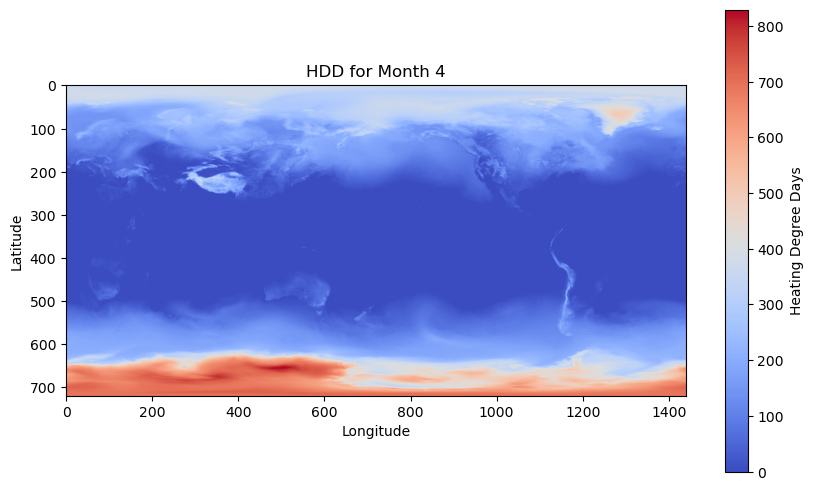

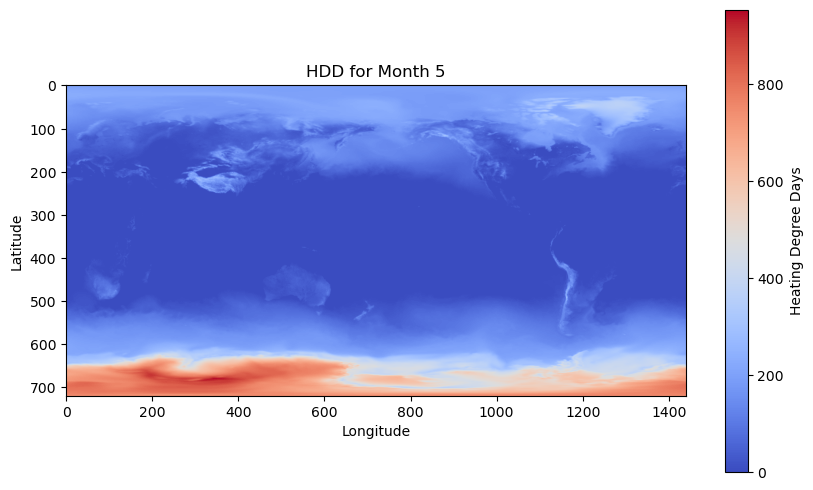

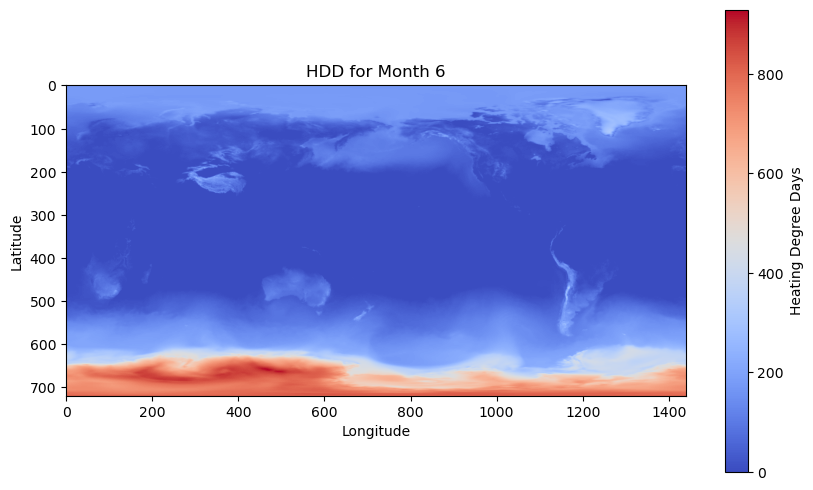

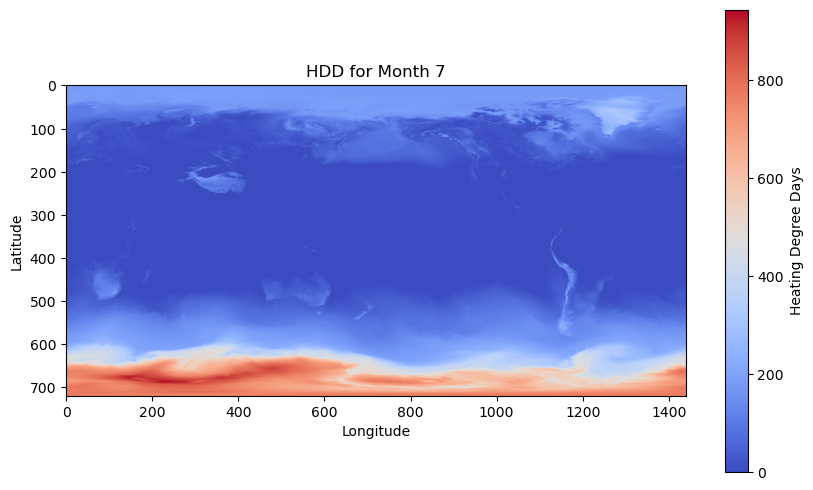

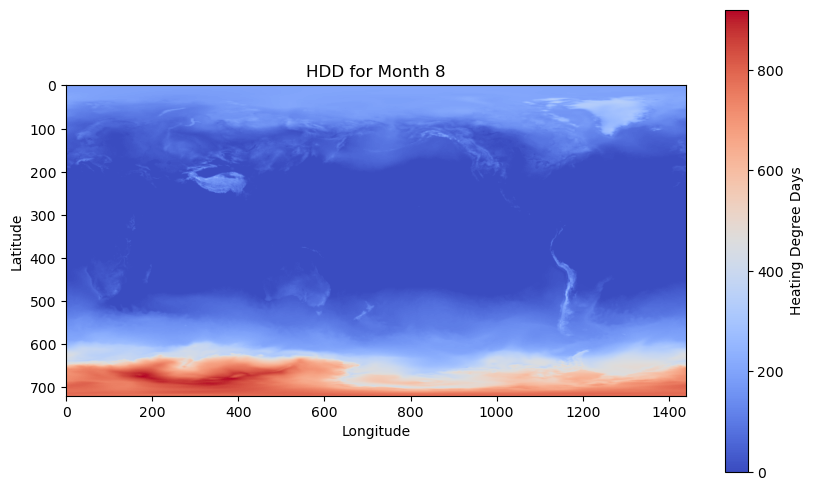

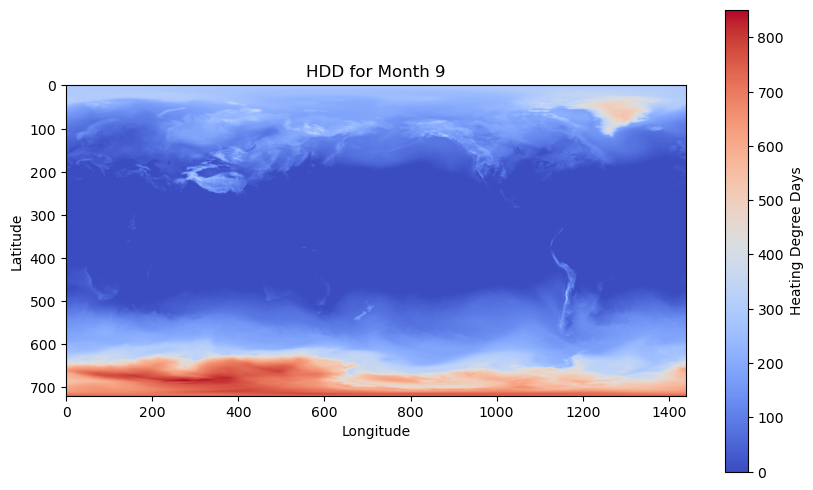

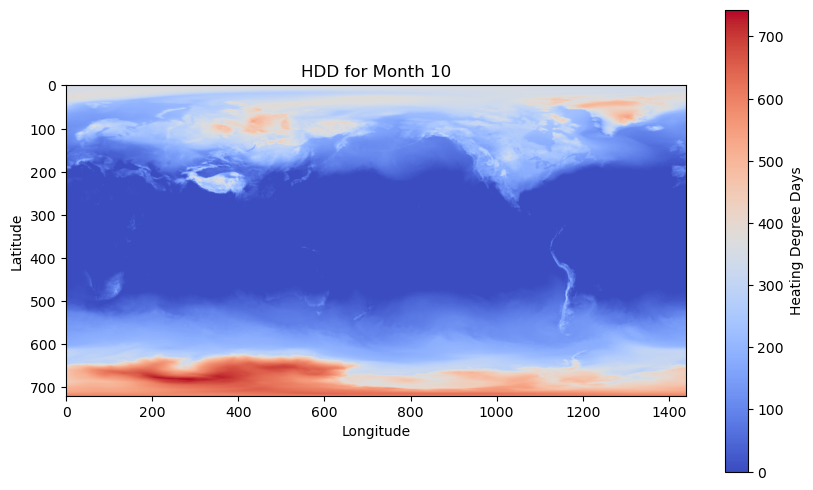

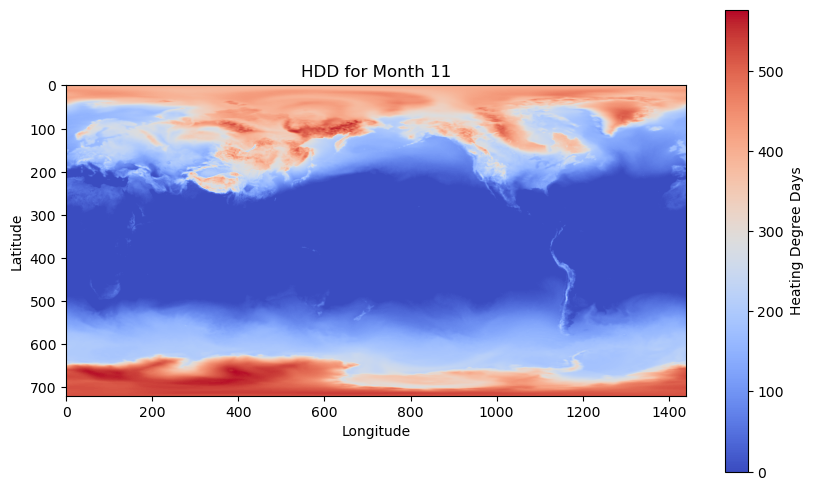

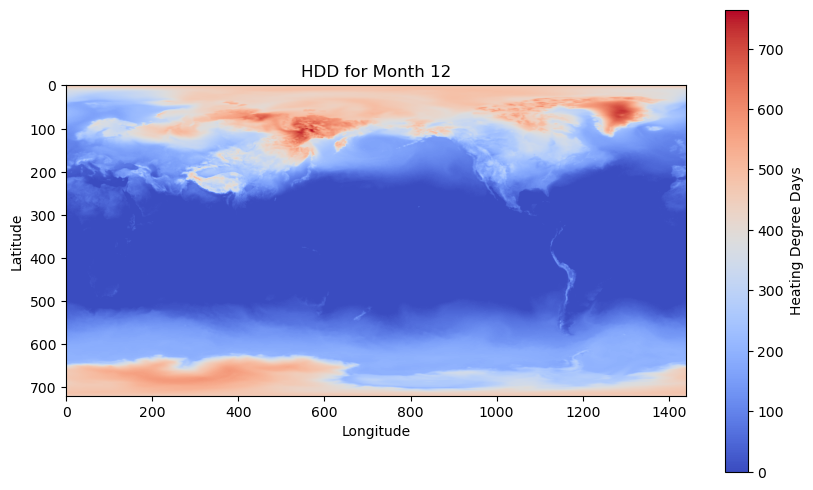

In [11]:
# visualization of hdd monthly
import matplotlib.pyplot as plt

for month in range(1, 13):
    hdd_flat = hdd_flat_dict[f"hdd_flat_{month}"]
    hdd_2d = hdd_flat.reshape(n_lat, n_lon)

    plt.figure(figsize=(10, 6))
    plt.imshow(hdd_2d, cmap="coolwarm", origin="upper")
    plt.colorbar(label="Heating Degree Days")
    plt.title(f"HDD for Month {month}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

In [12]:
# merge hdd monthly data into main table ---merged_df
from tqdm import tqdm

for i in range(1, 13):
    merged_df[f"nearest_hdd_{i}"] = np.nan
latitude = merged_df["latitude"]
longitude = merged_df["longitude"]

tree = cKDTree(np.column_stack((lat_flat, lon_flat)))

for index, row in tqdm(merged_df.iterrows(), total=merged_df.shape[0]):
    latitude = row["latitude"]
    longitude = row["longitude"]

    dist, idx = tree.query([latitude, longitude])
    for month in range(1, 13):
        hdd_flat = hdd_flat_dict[f"hdd_flat_{month}"]
        merged_df.at[index, f"nearest_hdd_{month}"] = hdd_flat[idx]

100%|██████████| 482/482 [00:00<00:00, 6254.79it/s]


In [13]:
merged_df

,geonameid,name,asciiname,alternatenames,latitude,longitude,feature class,feature code,iso alpha 2,cc2,...,nearest_hdd_3,nearest_hdd_4,nearest_hdd_5,nearest_hdd_6,nearest_hdd_7,nearest_hdd_8,nearest_hdd_9,nearest_hdd_10,nearest_hdd_11,nearest_hdd_12
0,292968,Abu Dhabi,Abu Dhabi,"A-pu-that-pi,AEbu Saby,AUH,Aboe Dhabi,Abou Dab...",24.45118,54.39696,P,PPLC,AE,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1138958,Kabul,Kabul,"Cabool,Caboul,Cabul,Cabura,Cabúl,Caubul,KBL,Ka...",34.52813,69.17233,P,PPLC,AF,NaN,...,0.000000,7.015475,4.241750,44.591157,48.598879,47.044252,24.307915,21.080207,7.237953,0.484769
2,3183875,Tirana,Tirana,"TIA,Terana,Theranda,Tiorana,Tiorána,Tiran,Tira...",41.32750,19.81889,P,PPLC,AL,NaN,...,15.555304,43.825452,57.600852,50.968761,91.140628,75.642559,82.533826,49.688605,20.027416,42.496259
3,616052,Yerevan,Yerevan,"Ayrivan,Djerevan,EVN,Eireavan,Eireaván,Ereban,...",40.18111,44.51361,P,PPLC,AM,NaN,...,12.323615,49.857435,49.876080,33.763358,49.348147,32.999900,21.805311,65.960578,67.675284,36.406253
4,2240449,Luanda,Luanda,"LAD,Loanda,Louanda,Louanta,Luand,Luanda,Luanda...",-8.83682,13.23432,P,PPLC,AO,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477,1018725,Bloemfontein,Bloemfontein,"BFN,Bloemfontein,Blumfantehjn,Blumfonteina,Blu...",-29.12107,26.21400,P,PPLA,ZA,NaN,...,35.471245,8.126959,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,28.261436,30.018873
478,3369157,Cape Town,Cape Town,"Altepetl In Cabo,Ar Chab,CPT,Cape Toun,Cape To...",-33.92584,18.42322,P,PPLA,ZA,NaN,...,25.936570,0.954678,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.756657
479,909137,Lusaka,Lusaka,"LUN,Lousaka,Louzaka,Lusaca,Lusak,Lusaka,Lusako...",-15.40669,28.28713,P,PPLC,ZM,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.091727,23.463806
480,890299,Harare,Harare,"Arare,Charare,HRE,Harare,Hararensis Urbs,Harar...",-17.82772,31.05337,P,PPLC,ZW,NaN,...,1.378190,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.001071


In [14]:
# visualize hdd in html

import folium
import pandas as pd
import matplotlib.cm as cm
import matplotlib.colors as colors


# Create a map centered around the average latitude and longitude
map_center = folium.Map(
    location=[merged_df["latitude"].mean(), merged_df["longitude"].mean()],
    zoom_start=10,
)

# Normalize HDD values to map colors
norm = colors.Normalize(
    vmin=merged_df["nearest_hdd_12"].min(), vmax=merged_df["nearest_hdd_12"].max()
)
colormap = cm.ScalarMappable(
    norm=norm, cmap="YlOrRd"
)  # Use a yellow-orange-red color map

# Add CircleMarkers with color gradient based on HDD
for _, row in merged_df.iterrows():
    color = colors.to_hex(
        colormap.to_rgba(row["nearest_hdd_5"])
    )  # Convert to hex for folium
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=8,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=f"HDD: {row['nearest_hdd_5']}",
        tooltip="Click for HDD value",
    ).add_to(map_center)

# Display the map
map_center.save("hdd_color_map_12.html")
import webbrowser

webbrowser.open("file://" + os.path.realpath("hdd_color_map_12.html"))

True

In [15]:
# caculate yearly total hdd and add monthly average and variance
import numpy as np

merged_df["total_year"] = merged_df[[f"nearest_hdd_{i}" for i in range(1, 7)]].sum(
    axis=1
)

merged_df["average_year"] = merged_df[[f"nearest_hdd_{i}" for i in range(1, 7)]].mean(
    axis=1
)

merged_df["variance_year"] = merged_df[[f"nearest_hdd_{i}" for i in range(1, 7)]].var(
    axis=1
)

In [16]:
merged_df

,geonameid,name,asciiname,alternatenames,latitude,longitude,feature class,feature code,iso alpha 2,cc2,...,nearest_hdd_6,nearest_hdd_7,nearest_hdd_8,nearest_hdd_9,nearest_hdd_10,nearest_hdd_11,nearest_hdd_12,total_year,average_year,variance_year
0,292968,Abu Dhabi,Abu Dhabi,"A-pu-that-pi,AEbu Saby,AUH,Aboe Dhabi,Abou Dab...",24.45118,54.39696,P,PPLC,AE,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1138958,Kabul,Kabul,"Cabool,Caboul,Cabul,Cabura,Cabúl,Caubul,KBL,Ka...",34.52813,69.17233,P,PPLC,AF,NaN,...,44.591157,48.598879,47.044252,24.307915,21.080207,7.237953,0.484769,55.848382,9.308064,307.148068
2,3183875,Tirana,Tirana,"TIA,Terana,Theranda,Tiorana,Tiorána,Tiran,Tira...",41.32750,19.81889,P,PPLC,AL,NaN,...,50.968761,91.140628,75.642559,82.533826,49.688605,20.027416,42.496259,189.011143,31.501857,474.002253
3,616052,Yerevan,Yerevan,"Ayrivan,Djerevan,EVN,Eireavan,Eireaván,Ereban,...",40.18111,44.51361,P,PPLC,AM,NaN,...,33.763358,49.348147,32.999900,21.805311,65.960578,67.675284,36.406253,187.031386,31.171898,426.687581
4,2240449,Luanda,Luanda,"LAD,Loanda,Louanda,Louanta,Luand,Luanda,Luanda...",-8.83682,13.23432,P,PPLC,AO,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477,1018725,Bloemfontein,Bloemfontein,"BFN,Bloemfontein,Blumfantehjn,Blumfonteina,Blu...",-29.12107,26.21400,P,PPLA,ZA,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,28.261436,30.018873,132.058805,22.009801,605.624815
478,3369157,Cape Town,Cape Town,"Altepetl In Cabo,Ar Chab,CPT,Cape Toun,Cape To...",-33.92584,18.42322,P,PPLA,ZA,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.756657,75.547166,12.591194,209.416498
479,909137,Lusaka,Lusaka,"LUN,Lousaka,Louzaka,Lusaca,Lusak,Lusaka,Lusako...",-15.40669,28.28713,P,PPLC,ZM,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.091727,23.463806,9.997842,1.666307,16.659475
480,890299,Harare,Harare,"Arare,Charare,HRE,Harare,Hararensis Urbs,Harar...",-17.82772,31.05337,P,PPLC,ZW,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.001071,3.801839,0.633640,1.072897


In [17]:
output_path = "../data/processed"
os.makedirs(output_path, exist_ok=True)

merged_df.to_csv(os.path.join(output_path, "merged_df_HDD.csv"), index=False)

## Humidity

In [38]:
from scipy.spatial import cKDTree
import numpy as np
import pandas as pd
from tqdm import tqdm
import xarray as xr
import rasterio

# File template for monthly humidity data
file_humidity_template = "/Users/leilei/Documents/MIDS/2024 Fall/Capstone/Capstone-Team-Climate-Trace/combined_2023{}.nc"

# Placeholder dictionary to store flattened humidity data
humidity_flat_dict = {}

# Extract and flatten humidity data for each month
for month in range(1, 13):
    file_path = file_humidity_template.format(month)
    
    # Load the NetCDF file for humidity
    with xr.open_dataset(file_path) as ds:
        # Assuming 'humidity' is the variable name in the NetCDF file
        humidity = ds['d2m'].mean(dim='time').values  # Monthly average
        latitudes = ds['latitude'].values
        longitudes = ds['longitude'].values

        # Flatten the humidity data and create coordinate grids
        lon_grid, lat_grid = np.meshgrid(longitudes, latitudes)
        humidity_flat_dict[f"humidity_flat_{month}"] = humidity.ravel()

# Create the KDTree for spatial interpolation
lat_flat = lat_grid.ravel()
lon_flat = lon_grid.ravel()
tree = cKDTree(np.column_stack((lat_flat, lon_flat)))

# Add monthly humidity columns to the merged DataFrame
for month in range(1, 13):
    merged_df[f"nearest_humidity_{month}"] = np.nan

# Interpolate and assign nearest humidity values to each row in merged_df
for index, row in tqdm(merged_df.iterrows(), total=merged_df.shape[0]):
    latitude = row["latitude"]
    longitude = row["longitude"]

    dist, idx = tree.query([latitude, longitude])  # Find nearest point
    for month in range(1, 13):
        humidity_flat = humidity_flat_dict[f"humidity_flat_{month}"]
        merged_df.at[index, f"nearest_humidity_{month}"] = humidity_flat[idx]

# The merged_df now contains the nearest humidity values for all 12 months


100%|██████████| 482/482 [00:00<00:00, 2946.21it/s]


In [39]:
merged_df

,geonameid,name,asciiname,alternatenames,latitude,longitude,feature class,feature code,iso alpha 2,cc2,...,nearest_humidity_3,nearest_humidity_4,nearest_humidity_5,nearest_humidity_6,nearest_humidity_7,nearest_humidity_8,nearest_humidity_9,nearest_humidity_10,nearest_humidity_11,nearest_humidity_12
0,292968,Abu Dhabi,Abu Dhabi,"A-pu-that-pi,AEbu Saby,AUH,Aboe Dhabi,Abou Dab...",24.45118,54.39696,P,PPLC,AE,NaN,...,289.300690,286.040588,299.554047,300.441376,300.277313,298.629303,299.860474,294.487427,291.968201,292.326599
1,1138958,Kabul,Kabul,"Cabool,Caboul,Cabul,Cabura,Cabúl,Caubul,KBL,Ka...",34.52813,69.17233,P,PPLC,AF,NaN,...,274.537018,279.075745,280.163422,274.126923,281.710907,281.912537,275.858521,273.743286,270.800262,263.842255
2,3183875,Tirana,Tirana,"TIA,Terana,Theranda,Tiorana,Tiorána,Tiran,Tira...",41.32750,19.81889,P,PPLC,AL,NaN,...,279.695221,282.728088,287.593109,290.314423,292.384735,289.232849,287.028442,282.274536,278.858826,277.221130
3,616052,Yerevan,Yerevan,"Ayrivan,Djerevan,EVN,Eireavan,Eireaván,Ereban,...",40.18111,44.51361,P,PPLC,AM,NaN,...,272.038971,275.620667,277.423187,282.925751,284.347626,284.506287,281.713989,278.809692,265.147919,261.982880
4,2240449,Luanda,Luanda,"LAD,Loanda,Louanda,Louanta,Luand,Luanda,Luanda...",-8.83682,13.23432,P,PPLC,AO,NaN,...,297.062408,297.411713,293.268890,292.039032,291.251923,292.601959,292.987427,294.930786,296.745514,296.404694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477,1018725,Bloemfontein,Bloemfontein,"BFN,Bloemfontein,Blumfantehjn,Blumfonteina,Blu...",-29.12107,26.21400,P,PPLA,ZA,NaN,...,280.169830,273.942932,280.434906,273.558563,267.132782,271.590302,275.372192,276.991333,277.405701,287.094177
478,3369157,Cape Town,Cape Town,"Altepetl In Cabo,Ar Chab,CPT,Cape Toun,Cape To...",-33.92584,18.42322,P,PPLA,ZA,NaN,...,286.992096,282.765198,286.106781,285.232391,282.195282,284.926208,285.733521,282.587036,287.124451,290.226990
479,909137,Lusaka,Lusaka,"LUN,Lousaka,Louzaka,Lusaca,Lusak,Lusaka,Lusako...",-15.40669,28.28713,P,PPLC,ZM,NaN,...,288.572174,282.933167,284.782562,280.746063,275.359344,279.037537,283.128052,289.637817,289.665466,292.012146
480,890299,Harare,Harare,"Arare,Charare,HRE,Harare,Hararensis Urbs,Harar...",-17.82772,31.05337,P,PPLC,ZW,NaN,...,289.074127,278.161682,283.429047,278.486298,275.761688,277.961365,286.038208,286.296021,288.095154,289.654724


In [ ]:
# Add a new column for the average humidity across all 12 months
# merged_df['average_humidity'] = merged_df[[f"nearest_humidity_{i}" for i in range(1, 13)]].mean(axis=1)
merged_df

,geonameid,name,asciiname,alternatenames,latitude,longitude,feature class,feature code,iso alpha 2,cc2,...,nearest_humidity_4,nearest_humidity_5,nearest_humidity_6,nearest_humidity_7,nearest_humidity_8,nearest_humidity_9,nearest_humidity_10,nearest_humidity_11,nearest_humidity_12,average_humidity
0,292968,Abu Dhabi,Abu Dhabi,"A-pu-that-pi,AEbu Saby,AUH,Aboe Dhabi,Abou Dab...",24.45118,54.39696,P,PPLC,AE,NaN,...,286.040588,299.554047,300.441376,300.277313,298.629303,299.860474,294.487427,291.968201,292.326599,293.934863
1,1138958,Kabul,Kabul,"Cabool,Caboul,Cabul,Cabura,Cabúl,Caubul,KBL,Ka...",34.52813,69.17233,P,PPLC,AF,NaN,...,279.075745,280.163422,274.126923,281.710907,281.912537,275.858521,273.743286,270.800262,263.842255,273.259097
2,3183875,Tirana,Tirana,"TIA,Terana,Theranda,Tiorana,Tiorána,Tiran,Tira...",41.32750,19.81889,P,PPLC,AL,NaN,...,282.728088,287.593109,290.314423,292.384735,289.232849,287.028442,282.274536,278.858826,277.221130,283.286924
3,616052,Yerevan,Yerevan,"Ayrivan,Djerevan,EVN,Eireavan,Eireaván,Ereban,...",40.18111,44.51361,P,PPLC,AM,NaN,...,275.620667,277.423187,282.925751,284.347626,284.506287,281.713989,278.809692,265.147919,261.982880,274.528951
4,2240449,Luanda,Luanda,"LAD,Loanda,Louanda,Louanta,Luand,Luanda,Luanda...",-8.83682,13.23432,P,PPLC,AO,NaN,...,297.411713,293.268890,292.039032,291.251923,292.601959,292.987427,294.930786,296.745514,296.404694,294.898076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477,1018725,Bloemfontein,Bloemfontein,"BFN,Bloemfontein,Blumfantehjn,Blumfonteina,Blu...",-29.12107,26.21400,P,PPLA,ZA,NaN,...,273.942932,280.434906,273.558563,267.132782,271.590302,275.372192,276.991333,277.405701,287.094177,278.273572
478,3369157,Cape Town,Cape Town,"Altepetl In Cabo,Ar Chab,CPT,Cape Toun,Cape To...",-33.92584,18.42322,P,PPLA,ZA,NaN,...,282.765198,286.106781,285.232391,282.195282,284.926208,285.733521,282.587036,287.124451,290.226990,285.727997
479,909137,Lusaka,Lusaka,"LUN,Lousaka,Louzaka,Lusaca,Lusak,Lusaka,Lusako...",-15.40669,28.28713,P,PPLC,ZM,NaN,...,282.933167,284.782562,280.746063,275.359344,279.037537,283.128052,289.637817,289.665466,292.012146,285.696259
480,890299,Harare,Harare,"Arare,Charare,HRE,Harare,Hararensis Urbs,Harar...",-17.82772,31.05337,P,PPLC,ZW,NaN,...,278.161682,283.429047,278.486298,275.761688,277.961365,286.038208,286.296021,288.095154,289.654724,284.247528
